In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e10/sample_submission.csv
/kaggle/input/playground-series-s5e10/train.csv
/kaggle/input/playground-series-s5e10/test.csv


**Cell 1: Imports and Setup**

In [2]:
# %% [code]
# Core libraries
import pandas as pd
import numpy as np
import time
import os
import gc  # Import garbage collector
import warnings

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling tools
from sklearn.model_selection import KFold, StratifiedKFold  # Import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize

# Models
import xgboost as xgb
import lightgbm as lgb
import optuna

# Disable warnings
warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING) # Reduce Optuna logs

print("Libraries imported.")

Libraries imported.


**Cell 2: Load Data and Configuration******

In [10]:
# %% [code]
# --- Configuration ---
DATA_PATH = "/kaggle/input/playground-series-s5e10/"
SUBMISSION_FILENAME = "submission_v2_stratified_optuna_fixed.csv" # Updated filename
RANDOM_STATE = 42
N_SPLITS_CV = 5 # Number of folds for main CV and OOF generation
N_SPLITS_OPTUNA = 5 # Number of folds for Optuna's internal CV
N_TRIALS_OPTUNA = 30 # Number of Optuna trials (Adjust based on time)
EARLY_STOPPING_ROUNDS_OPTUNA = 50
EARLY_STOPPING_ROUNDS_CV = 100
HIGH_N_ESTIMATORS = 8000 # Increased limit for early stopping

# --- Load Data ---
print("Loading data...")
try:
    train_df = pd.read_csv(os.path.join(DATA_PATH, "train.csv"))
    test_df = pd.read_csv(os.path.join(DATA_PATH, "test.csv"))
    sample_submission = pd.read_csv(os.path.join(DATA_PATH, "sample_submission.csv"))
except FileNotFoundError:
    print("Dataset not found at Kaggle path. Ensure data source is attached.")
    # Add local paths here if needed for testing

# Preserve for submission
test_ids = test_df['id']
# Store original train index for OOF saving later
original_train_ids = train_df['id'] # Assuming 'id' is the index column, adjust if not

# Separate target
y = train_df['accident_risk']
train_df_ids = train_df['id'] # Keep IDs if needed for OOF df
train_df = train_df.drop(columns=["accident_risk", "id"]) # Drop target and ID from features
test_df = test_df.drop(columns=["id"])

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)
print("Data loaded.")

Loading data...
Train shape: (517754, 12)
Test shape: (172585, 12)
Data loaded.


**Cell 3: Feature Engineering**

In [4]:
# %% [code]
def create_features(df):
    """
    Creates new features from the input DataFrame.
    Assumes original columns like 'road_surface', 'weather', etc., exist.
    """
    df_new = df.copy()

    # --- Original Numeric FE ---
    df_new['speed_limit_sq'] = df_new['speed_limit']**2
    df_new['curvature_sq'] = df_new['curvature']**2
    df_new['speed_x_curvature'] = df_new['speed_limit'] * df_new['curvature']
    df_new['speed_x_lanes'] = df_new['speed_limit'] * df_new['num_lanes']
    df_new['accident_density'] = df_new['num_reported_accidents'] / (df_new['num_lanes'] + 1)
    df_new['curvature_per_lane'] = df_new['curvature'] / (df_new['num_lanes'] + 1)

    # --- Corrected Categorical Interactions (BEFORE OHE) ---
    # Check if columns exist before creating interactions to avoid KeyErrors
    if 'weather' in df_new.columns and 'lighting' in df_new.columns:
        df_new['weather_lighting'] = df_new['weather'].astype(str) + '_' + df_new['lighting'].astype(str)
    if 'road_surface' in df_new.columns and 'weather' in df_new.columns:
        df_new['road_surface_weather'] = df_new['road_surface'].astype(str) + '_' + df_new['weather'].astype(str)
    if 'intersection_type' in df_new.columns and 'lighting' in df_new.columns:
        df_new['intersection_lighting'] = df_new['intersection_type'].astype(str) + '_' + df_new['lighting'].astype(str)
    if 'time_of_day' in df_new.columns and 'school_season' in df_new.columns:
        df_new['time_season'] = df_new['time_of_day'].astype(str) + '_' + df_new['school_season'].astype(str)

    # --- New Numeric FE Ideas ---
    if 'num_reported_accidents' in df_new.columns and 'avg_daily_traffic' in df_new.columns:
        df_new['accidents_per_vehicle'] = df_new['num_reported_accidents'] / (df_new['avg_daily_traffic'] + 1)
    if 'avg_daily_traffic' in df_new.columns and 'curvature' in df_new.columns and 'speed_limit' in df_new.columns:
        df_new['traffic_complexity'] = df_new['avg_daily_traffic'] * df_new['curvature'] / (df_new['speed_limit'] + 1)
    if 'speed_limit' in df_new.columns and 'avg_daily_traffic' in df_new.columns and 'num_lanes' in df_new.columns:
        df_new['speed_traffic_density'] = df_new['speed_limit'] * df_new['avg_daily_traffic'] / (df_new['num_lanes'] + 1)

    # Simple log transforms
    if 'avg_daily_traffic' in df_new.columns:
        df_new['log_traffic'] = np.log1p(df_new['avg_daily_traffic'])
    if 'num_reported_accidents' in df_new.columns:
        df_new['log_accidents'] = np.log1p(df_new['num_reported_accidents'])

    # Replace potentially infinite values created by division
    df_new.replace([np.inf, -np.inf], 0, inplace=True) # Use 0 or another sensible value like NaN

    return df_new

print("Applying Feature Engineering...")
# Ensure train_df and test_df have the original columns before calling
# Add checks here if needed: print(train_df.columns)
X = create_features(train_df)
X_test = create_features(test_df)

# Identify categorical features for encoding later (original + new interactions)
# Make sure to include newly created interaction columns if they are object type
categorical_features = X.select_dtypes(include=['object', 'bool']).columns.tolist()

# Ensure boolean columns are treated as categories before identifying them
bool_cols = X.select_dtypes(include=['bool']).columns
if len(bool_cols) > 0:
    X[bool_cols] = X[bool_cols].astype('category')
    X_test[bool_cols] = X_test[bool_cols].astype('category') # Apply to test set too
    # Re-identify after type conversion
    categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()


print(f"Shape after FE - Train: {X.shape}, Test: {X_test.shape}")
print(f"Identified {len(categorical_features)} categorical features for OHE.")
# print(categorical_features) # Uncomment to see the list

Applying Feature Engineering...
Shape after FE - Train: (517754, 21), Test: (172585, 21)
Identified 10 categorical features for OHE.


**Cell 4: One-Hot Encoding & Alignment**

In [5]:
# %% [code]
print("Applying One-Hot Encoding...")
X_encoded = pd.get_dummies(X, columns=categorical_features, drop_first=True, dummy_na=False) # dummy_na=False is safer
X_test_encoded = pd.get_dummies(X_test, columns=categorical_features, drop_first=True, dummy_na=False)

print("Aligning columns...")
train_cols = X_encoded.columns
test_cols = X_test_encoded.columns

missing_in_test = list(set(train_cols) - set(test_cols))
for col in missing_in_test:
    X_test_encoded[col] = 0 # OHE creates numeric (0/1)

missing_in_train = list(set(test_cols) - set(train_cols))
for col in missing_in_train:
    X_encoded[col] = 0 # Should not happen if test has subset of categories

# Ensure same column order
X_test_encoded = X_test_encoded[train_cols]

print(f"Shape after OHE - Train: {X_encoded.shape}, Test: {X_test_encoded.shape}")
assert all(X_encoded.columns == X_test_encoded.columns)
print("Column alignment successful.")

# Store feature names for later use (e.g., importance plot)
feature_names = X_encoded.columns.tolist()

# Clean up memory
del X, X_test, train_df, test_df
gc.collect()

Applying One-Hot Encoding...
Aligning columns...
Shape after OHE - Train: (517754, 36), Test: (172585, 36)
Column alignment successful.


0

**Cell 5: Scaling**

In [6]:
# %% [code]
print("Scaling features...")
# Note: Best practice is to fit scaler inside each CV fold.
# For simplicity here, we fit globally, acknowledging a tiny potential info leak in CV scores.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

print("Scaling complete.")
print(f"Scaled data shape - Train: {X_scaled.shape}, Test: {X_test_scaled.shape}")

# Clean up memory
del X_encoded, X_test_encoded
gc.collect()

Scaling features...
Scaling complete.
Scaled data shape - Train: (517754, 36), Test: (172585, 36)


0

**Cell 6: Optuna Hyperparameter Tuning (with StratifiedKFold and corrected objective)**

In [7]:
# %% [code]
# --- (Keep y_binned creation from previous cell just in case, but we won't use it in KFold here) ---
# try:
#     y_binned = pd.qcut(y, q=10, labels=False, duplicates='drop')
#     print("Created 10 bins for potential StratifiedKFold (currently using KFold).")
# except ValueError:
#     try:
#         y_binned = pd.qcut(y, q=5, labels=False, duplicates='drop')
#         print("Created 5 bins for potential StratifiedKFold (currently using KFold).")
#     except ValueError:
#         print("Warning: Could not create bins for stratification. Using KFold.")
#         y_binned = None # Flag that binning failed or wasn't used

# --- Updated Configuration ---
EARLY_STOPPING_ROUNDS_OPTUNA_UPDATED = 100 # Keep increased patience

# --- Base Parameters (Corrected LGBM Objective) ---
LGBM_BASE_PARAMS = {
    'objective': 'regression',
    'metric': 'rmse',
    'random_state': RANDOM_STATE,
    'n_jobs': -1,
    'boosting_type': 'gbdt',
    'verbosity': -1, # Suppress LightGBM's default verbosity to better see warnings
}

XGB_BASE_PARAMS = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'random_state': RANDOM_STATE,
    'n_jobs': -1,
    'tree_method': 'hist',
    'verbosity': 0, # Suppress XGBoost verbosity
}

# --- List to store parameters of failing trials ---
lgbm_failing_trials_log = []
xgb_failing_trials_log = [] # Added for XGB consistency

# --- Optuna Objective Functions (Revised Search Space, KFold, Diagnostics) ---
def lgbm_objective(trial):
    # Enforce num_leaves constraint based on max_depth
    max_depth = trial.suggest_int('max_depth', 4, 10) # Slightly reduced max
    max_leaves_for_depth = 2 ** max_depth
    # Suggest num_leaves within a sensible range, capped by max_depth
    num_leaves = trial.suggest_int('num_leaves', 15, min(150, max_leaves_for_depth)) # Reduced max leaves

    params = LGBM_BASE_PARAMS.copy()
    params.update({
        'n_estimators': HIGH_N_ESTIMATORS,
        'learning_rate': trial.suggest_float('learning_rate', 0.008, 0.04, log=True), # Slightly adjusted LR range
        'num_leaves': num_leaves,
        'max_depth': max_depth,
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 60), # More conservative max
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 60), # Added this, similar range
        'subsample': trial.suggest_float('subsample', 0.65, 0.95), # Start slightly higher
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.65, 0.95), # Start slightly higher
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-5, 1.0, log=True), # Max 1.0
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-5, 1.0, log=True), # Max 1.0
        # 'min_gain_to_split': 0.0, # Using default (removed from tuning)
        'bagging_freq': 1 if trial.suggest_float('subsample', 0.65, 0.95) < 1.0 else 0, # Enable bagging if subsample is used
        'max_bin': trial.suggest_int('max_bin', 100, 255), # Added max_bin tuning
    })
    # Ensure subsample matches bagging_fraction if used
    params['bagging_fraction'] = params['subsample']


    # Use standard KFold for regression unless stratification is proven necessary and reliable
    kf = KFold(n_splits=N_SPLITS_OPTUNA, shuffle=True, random_state=RANDOM_STATE)
    rmse_scores = []
    warning_count = 0

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_scaled, y)): # Use y for splitting with KFold
        X_tr, X_val = X_scaled[train_idx], X_scaled[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model = lgb.LGBMRegressor(**params)

        try:
            # Capture warnings during fit
            with warnings.catch_warnings(record=True) as caught_warnings:
                warnings.simplefilter("always", UserWarning) # Adjust filter as needed
                model.fit(X_tr, y_tr,
                          eval_set=[(X_val, y_val)],
                          eval_metric='rmse',
                          callbacks=[lgb.early_stopping(EARLY_STOPPING_ROUNDS_OPTUNA_UPDATED, verbose=False)])

                # Check specifically for the "No further splits" warning
                for w in caught_warnings:
                    if "No further splits with positive gain" in str(w.message):
                        warning_count += 1

            # Check if model built any trees or stopped immediately
            if model.best_iteration_ is None or model.best_iteration_ <= 1:
                 # Treat immediate stopping or no trees as a failure for this fold
                 print(f"  -> Trial {trial.number}, Fold {fold}: Stopped early ({model.best_iteration_} iters) or failed. High RMSE.")
                 rmse_scores.append(1.0) # Assign a high RMSE
                 lgbm_failing_trials_log.append({'trial': trial.number, 'params': params, 'reason': 'Immediate Stop/No Trees'})
                 continue # Move to next fold for this trial

            preds = model.predict(X_val, num_iteration=model.best_iteration_)
            rmse = np.sqrt(mean_squared_error(y_val, preds))

            # Check for near-constant predictions (another sign of failure)
            if np.std(preds) < 1e-7:
                print(f"  -> Trial {trial.number}, Fold {fold}: Near constant predictions (std={np.std(preds):.2e}). High RMSE.")
                rmse_scores.append(1.0) # Assign high RMSE
                lgbm_failing_trials_log.append({'trial': trial.number, 'params': params, 'reason': 'Constant Preds'})
                continue

            rmse_scores.append(rmse)

        except Exception as e:
            print(f"  -> Trial {trial.number}, Fold {fold}: Failed with Exception: {str(e)}")
            lgbm_failing_trials_log.append({'trial': trial.number, 'params': params, 'reason': f'Exception: {str(e)}'})
            rmse_scores.append(1.0) # Penalize heavily
            continue # Move to next fold

        finally:
             # Clean up model regardless of outcome
             del model, X_tr, X_val, y_tr, y_val
             gc.collect()

    if not rmse_scores: # If all folds failed
         print(f"  -> Trial {trial.number}: All folds failed.")
         return 1.0 # Return high value

    avg_rmse = np.mean(rmse_scores)

    # Log if many warnings occurred
    if warning_count > N_SPLITS_OPTUNA // 2 : # If warnings in more than half the folds
        print(f"  -> Trial {trial.number}: Frequent 'No split' warnings ({warning_count}/{N_SPLITS_OPTUNA}). Avg RMSE: {avg_rmse:.6f}")
        # Optionally log these params too, or just rely on the checks above
        # lgbm_failing_trials_log.append({'trial': trial.number, 'params': params, 'reason': 'Frequent Warnings'})


    # Check for NaN/Inf final RMSE
    if np.isnan(avg_rmse) or np.isinf(avg_rmse):
        print(f"  -> Trial {trial.number}: Resulted in NaN/Inf RMSE.")
        lgbm_failing_trials_log.append({'trial': trial.number, 'params': params, 'reason': 'NaN/Inf RMSE'})
        return 1.0 # Return high value

    trial.report(avg_rmse, step=0)
    if trial.should_prune():
           raise optuna.TrialPruned()
    return avg_rmse

# --- XGB Objective (Apply similar robustness checks and KFold) ---
def xgb_objective(trial):
    params = XGB_BASE_PARAMS.copy()
    params.update({
        'n_estimators': HIGH_N_ESTIMATORS,
        'learning_rate': trial.suggest_float('learning_rate', 0.008, 0.04, log=True),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'subsample': trial.suggest_float('subsample', 0.65, 0.95),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.65, 0.95),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 8), # Slightly reduced max
        'gamma': trial.suggest_float('gamma', 0, 2), # Reduced max
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-5, 1.0, log=True), # Max 1.0
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-5, 1.0, log=True), # Max 1.0
    })

    # Use standard KFold
    kf = KFold(n_splits=N_SPLITS_OPTUNA, shuffle=True, random_state=RANDOM_STATE)
    rmse_scores = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X_scaled, y)):
        X_tr, X_val = X_scaled[train_idx], X_scaled[val_idx]
        y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

        model = xgb.XGBRegressor(**params)
        try:
            model.fit(X_tr, y_tr,
                      eval_set=[(X_val, y_val)],
                      early_stopping_rounds=EARLY_STOPPING_ROUNDS_OPTUNA_UPDATED,
                      verbose=False)

            if model.best_iteration is None or model.best_iteration <= 1:
                print(f"  -> Trial {trial.number}, Fold {fold} (XGB): Stopped early ({model.best_iteration} iters) or failed. High RMSE.")
                rmse_scores.append(1.0)
                xgb_failing_trials_log.append({'trial': trial.number, 'params': params, 'reason': 'Immediate Stop/No Trees'})
                continue

            preds = model.predict(X_val, iteration_range=(0, model.best_iteration + 1))
            rmse = np.sqrt(mean_squared_error(y_val, preds))

            if np.std(preds) < 1e-7:
                print(f"  -> Trial {trial.number}, Fold {fold} (XGB): Near constant predictions (std={np.std(preds):.2e}). High RMSE.")
                rmse_scores.append(1.0)
                xgb_failing_trials_log.append({'trial': trial.number, 'params': params, 'reason': 'Constant Preds'})
                continue

            rmse_scores.append(rmse)

        except Exception as e:
            print(f"  -> Trial {trial.number}, Fold {fold} (XGB): Failed with Exception: {str(e)}")
            xgb_failing_trials_log.append({'trial': trial.number, 'params': params, 'reason': f'Exception: {str(e)}'})
            rmse_scores.append(1.0)
            continue

        finally:
            del model, X_tr, X_val, y_tr, y_val
            gc.collect()

    if not rmse_scores:
        print(f"  -> Trial {trial.number} (XGB): All folds failed.")
        return 1.0

    avg_rmse = np.mean(rmse_scores)

    if np.isnan(avg_rmse) or np.isinf(avg_rmse):
        print(f"  -> Trial {trial.number} (XGB): Resulted in NaN/Inf RMSE.")
        xgb_failing_trials_log.append({'trial': trial.number, 'params': params, 'reason': 'NaN/Inf RMSE'})
        return 1.0

    trial.report(avg_rmse, step=0)
    if trial.should_prune():
           raise optuna.TrialPruned()
    return avg_rmse

# --- Run Optuna Studies ---
print(f"--- Starting Optuna HPT ({N_TRIALS_OPTUNA} trials each) with final revised spaces ---")
hpt_start_time = time.time()

print("\nTuning LGBM...")
lgbm_study = optuna.create_study(direction='minimize',
                                 # Consider TPESampler with startup trials or CmaEsSampler if issues persist
                                 # sampler=optuna.samplers.TPESampler(n_startup_trials=10, seed=RANDOM_STATE),
                                 pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=5))
lgbm_study.optimize(lgbm_objective, n_trials=N_TRIALS_OPTUNA, show_progress_bar=True, gc_after_trial=True, catch=()) # catch=() shows errors
best_lgbm_params_tuned = lgbm_study.best_params
best_lgbm_params = LGBM_BASE_PARAMS.copy()
best_lgbm_params.update(best_lgbm_params_tuned)
print(f"Best LGBM CV RMSE (Optuna): {lgbm_study.best_value:.6f}")
print("Best LGBM Parameters found:")
print(best_lgbm_params)


print("\nTuning XGB...")
xgb_study = optuna.create_study(direction='minimize',
                                # sampler=optuna.samplers.TPESampler(n_startup_trials=10, seed=RANDOM_STATE),
                                pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=5))
xgb_study.optimize(xgb_objective, n_trials=N_TRIALS_OPTUNA, show_progress_bar=True, gc_after_trial=True, catch=()) # catch=() shows errors
best_xgb_params_tuned = xgb_study.best_params
best_xgb_params = XGB_BASE_PARAMS.copy()
best_xgb_params.update(best_xgb_params_tuned)
print(f"Best XGB CV RMSE (Optuna): {xgb_study.best_value:.6f}")
print("Best XGB Parameters found:")
print(best_xgb_params)

hpt_end_time = time.time()
print(f"\n--- HPT Complete in {(hpt_end_time - hpt_start_time) / 60:.2f} minutes ---")

# --- Analyze Failing Trials (Optional) ---
if lgbm_failing_trials_log:
    print(f"\n--- Found {len(lgbm_failing_trials_log)} instances of LGBM trial issues ---")
    # Convert log to DataFrame for easier analysis
    fail_df = pd.DataFrame(lgbm_failing_trials_log)
    print(fail_df['reason'].value_counts())
    # You could save this df or print more details
    # fail_df.to_csv("lgbm_optuna_failing_trials_summary.csv", index=False)
    # print(fail_df.head())

if xgb_failing_trials_log:
     print(f"\n--- Found {len(xgb_failing_trials_log)} instances of XGB trial issues ---")
     fail_df_xgb = pd.DataFrame(xgb_failing_trials_log)
     print(fail_df_xgb['reason'].value_counts())

--- Starting Optuna HPT (30 trials each) with final revised spaces ---

Tuning LGBM...


  0%|          | 0/30 [00:00<?, ?it/s]

Best LGBM CV RMSE (Optuna): 0.056066
Best LGBM Parameters found:
{'objective': 'regression', 'metric': 'rmse', 'random_state': 42, 'n_jobs': -1, 'boosting_type': 'gbdt', 'verbosity': -1, 'max_depth': 10, 'num_leaves': 145, 'learning_rate': 0.011249697383820471, 'min_child_samples': 19, 'min_data_in_leaf': 11, 'subsample': 0.7968291437475814, 'colsample_bytree': 0.9473781206017353, 'reg_alpha': 0.00026740972083722555, 'reg_lambda': 0.02178644869479638, 'max_bin': 219}

Tuning XGB...


  0%|          | 0/30 [00:00<?, ?it/s]

Best XGB CV RMSE (Optuna): 0.056096
Best XGB Parameters found:
{'objective': 'reg:squarederror', 'eval_metric': 'rmse', 'random_state': 42, 'n_jobs': -1, 'tree_method': 'hist', 'verbosity': 0, 'learning_rate': 0.01739264523809876, 'max_depth': 7, 'subsample': 0.8683981412878885, 'colsample_bytree': 0.7591126749534279, 'min_child_weight': 2, 'gamma': 0.002854891370123777, 'reg_alpha': 4.801546697615941e-05, 'reg_lambda': 0.3559396456178308}

--- HPT Complete in 298.99 minutes ---


**Cell 7: K-Fold CV for OOF Generation & Test Predictions (with fixes)**

In [12]:
# %% [code]
# --- Create bins for Stratified K-Fold for the main CV loop ---
print("Creating bins for StratifiedKFold...")
try:
    # Attempting 10 bins first
    y_binned = pd.qcut(y, q=10, labels=False, duplicates='drop')
    print("Using 10 bins for StratifiedKFold.")
    # Define skf as StratifiedKFold if binning is successful
    # Use uppercase N_SPLITS_CV as defined in Cell 2
    skf = StratifiedKFold(n_splits=N_SPLITS_CV, shuffle=True, random_state=RANDOM_STATE)
    use_stratification = True
except ValueError as e:
    print(f"Warning: Could not create 10 bins. Falling back to 5 bins. Error: {e}")
    try:
        # Fallback to 5 bins if 10 fails
        y_binned = pd.qcut(y, q=5, labels=False, duplicates='drop')
        print("Using 5 bins for StratifiedKFold.")
        # Define skf as StratifiedKFold if 5 bins work
        # Use uppercase N_SPLITS_CV
        skf = StratifiedKFold(n_splits=N_SPLITS_CV, shuffle=True, random_state=RANDOM_STATE)
        use_stratification = True
    except ValueError as e2:
        print(f"ERROR: Stratification binning failed. Using regular KFold instead. Error: {e2}")
        # Fallback to regular KFold if stratification fails
        # Use uppercase N_SPLITS_CV
        skf = KFold(n_splits=N_SPLITS_CV, shuffle=True, random_state=RANDOM_STATE)
        use_stratification = False # Flag that we are not using stratification

# --- Starting CV ---
print(f"--- Starting {N_SPLITS_CV}-Fold CV for OOF & Test Predictions ---")
if use_stratification:
    print("Using StratifiedKFold.")
else:
    print("Using KFold (stratification failed or fallback).")

# --- Initializations ---
oof_lgbm = np.zeros(len(X_scaled))
oof_xgb = np.zeros(len(X_scaled))
test_preds_lgbm = np.zeros(len(X_test_scaled))
test_preds_xgb = np.zeros(len(X_test_scaled))

lgbm_best_iterations = []
xgb_best_iterations = []
fold_rmse_scores_lgbm = []
fold_rmse_scores_xgb = []

cv_start_time = time.time()

# --- The Loop ---
# Determine how to split based on whether stratification is used
if use_stratification:
    # Ensure y_binned exists if stratification is intended
    if 'y_binned' not in locals() or y_binned is None:
         print("Error: use_stratification is True but y_binned is not defined. Defaulting to KFold.")
         skf = KFold(n_splits=N_SPLITS_CV, shuffle=True, random_state=RANDOM_STATE)
         use_stratification = False
         split_iterator = skf.split(X_scaled, y)
    else:
        split_iterator = skf.split(X_scaled, y_binned) # Use y_binned for splitting
else:
    split_iterator = skf.split(X_scaled, y) # Use y for standard KFold split

for fold, (train_idx, val_idx) in enumerate(split_iterator):
    print(f"\n--- Fold {fold+1}/{N_SPLITS_CV} ---")
    X_tr, X_val = X_scaled[train_idx], X_scaled[val_idx]
    y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # --- LGBM ---
    print("Training LGBM...")
    lgbm_params_fold = best_lgbm_params.copy()
    lgbm_params_fold['n_estimators'] = HIGH_N_ESTIMATORS # Use high number for ES

    model_lgbm = lgb.LGBMRegressor(**lgbm_params_fold)
    model_lgbm.fit(X_tr, y_tr,
                   eval_set=[(X_val, y_val)],
                   eval_metric='rmse',
                   callbacks=[lgb.early_stopping(EARLY_STOPPING_ROUNDS_CV, verbose=False)])

    if model_lgbm.best_iteration_ is None or model_lgbm.best_iteration_ <= 0 : # Check for valid iteration
         print(f"WARNING: LGBM Fold {fold+1} stopped early or failed. Using fallback iteration {HIGH_N_ESTIMATORS}.")
         lgbm_best_iterations.append(HIGH_N_ESTIMATORS) # Or consider a more robust fallback
         best_iter_lgbm = HIGH_N_ESTIMATORS
    else:
        lgbm_best_iterations.append(model_lgbm.best_iteration_)
        best_iter_lgbm = model_lgbm.best_iteration_
        print(f"LGBM Best Iteration: {best_iter_lgbm}")

    oof_preds_lgbm_fold = model_lgbm.predict(X_val, num_iteration=best_iter_lgbm)
    test_preds_lgbm_fold = model_lgbm.predict(X_test_scaled, num_iteration=best_iter_lgbm)

    oof_lgbm[val_idx] = oof_preds_lgbm_fold
    test_preds_lgbm += test_preds_lgbm_fold / N_SPLITS_CV

    rmse_lgbm = np.sqrt(mean_squared_error(y_val, oof_preds_lgbm_fold))
    fold_rmse_scores_lgbm.append(rmse_lgbm)
    print(f"LGBM Fold {fold+1} RMSE: {rmse_lgbm:.6f}")

    # --- XGB ---
    print("\nTraining XGB...")
    xgb_params_fold = best_xgb_params.copy()
    xgb_params_fold['n_estimators'] = HIGH_N_ESTIMATORS

    model_xgb = xgb.XGBRegressor(**xgb_params_fold)
    model_xgb.fit(X_tr, y_tr,
                  eval_set=[(X_val, y_val)],
                  early_stopping_rounds=EARLY_STOPPING_ROUNDS_CV,
                  verbose=False)

    if model_xgb.best_iteration is None or model_xgb.best_iteration <= 0: # Check for valid iteration
        print(f"WARNING: XGB Fold {fold+1} stopped early or failed. Using fallback iteration {HIGH_N_ESTIMATORS}.")
        xgb_best_iterations.append(HIGH_N_ESTIMATORS) # Or consider a more robust fallback
        best_iter_xgb = HIGH_N_ESTIMATORS
    else:
        xgb_best_iterations.append(model_xgb.best_iteration)
        best_iter_xgb = model_xgb.best_iteration
        print(f"XGB Best Iteration: {best_iter_xgb}")

    # --- CRITICAL FIX: Use best_iter_xgb + 1 for iteration_range ---
    oof_preds_xgb_fold = model_xgb.predict(X_val, iteration_range=(0, best_iter_xgb + 1))
    test_preds_xgb_fold = model_xgb.predict(X_test_scaled, iteration_range=(0, best_iter_xgb + 1))
    # --- End Fix ---

    oof_xgb[val_idx] = oof_preds_xgb_fold
    test_preds_xgb += test_preds_xgb_fold / N_SPLITS_CV

    rmse_xgb = np.sqrt(mean_squared_error(y_val, oof_preds_xgb_fold))
    fold_rmse_scores_xgb.append(rmse_xgb)
    print(f"XGB Fold {fold+1} RMSE: {rmse_xgb:.6f}")

    # --- Memory Management ---
    del model_lgbm, model_xgb, X_tr, X_val, y_tr, y_val
    gc.collect()

cv_end_time = time.time()
print(f"\n--- CV Complete in {(cv_end_time - cv_start_time) / 60:.2f} minutes ---")

# --- Calculate Overall OOF RMSE ---
# Add checks for NaN/Inf in OOF arrays before calculating RMSE
if np.isnan(oof_lgbm).any() or np.isinf(oof_lgbm).any():
    print("Warning: NaN or Inf found in LGBM OOF predictions.")
    oof_rmse_lgbm = np.nan # Or handle appropriately
else:
    oof_rmse_lgbm = np.sqrt(mean_squared_error(y, oof_lgbm))
    print(f"\nOverall LGBM OOF RMSE: {oof_rmse_lgbm:.6f}")

if np.isnan(oof_xgb).any() or np.isinf(oof_xgb).any():
    print("Warning: NaN or Inf found in XGB OOF predictions.")
    oof_rmse_xgb = np.nan # Or handle appropriately
else:
    oof_rmse_xgb = np.sqrt(mean_squared_error(y, oof_xgb))
    print(f"Overall XGB OOF RMSE:  {oof_rmse_xgb:.6f}")


# --- Calculate Robust Average Best Iterations (using 75th percentile) ---
# Ensure lists are not empty and contain valid numbers before calculating percentile
if lgbm_best_iterations and all(isinstance(x, (int, float)) and x > 0 for x in lgbm_best_iterations):
    final_lgbm_iterations = int(np.percentile(lgbm_best_iterations, 75))
else:
    final_lgbm_iterations = 1000 # Fallback default
    print("Warning: lgbm_best_iterations list is empty or contains invalid values! Using fallback.")

if xgb_best_iterations and all(isinstance(x, (int, float)) and x > 0 for x in xgb_best_iterations):
    final_xgb_iterations = int(np.percentile(xgb_best_iterations, 75))
else:
    final_xgb_iterations = 1000 # Fallback default
    print("Warning: xgb_best_iterations list is empty or contains invalid values! Using fallback.")

print(f"\nFinal LGBM Iterations (75th Percentile): {final_lgbm_iterations}")
print(f"Final XGB Iterations (75th Percentile):  {final_xgb_iterations}")

Creating bins for StratifiedKFold...
Using 10 bins for StratifiedKFold.
--- Starting 5-Fold CV for OOF & Test Predictions ---
Using StratifiedKFold.

--- Fold 1/5 ---
Training LGBM...
LGBM Best Iteration: 799
LGBM Fold 1 RMSE: 0.056143

Training XGB...
XGB Best Iteration: 856
XGB Fold 1 RMSE: 0.056157

--- Fold 2/5 ---
Training LGBM...
LGBM Best Iteration: 735
LGBM Fold 2 RMSE: 0.055965

Training XGB...
XGB Best Iteration: 784
XGB Fold 2 RMSE: 0.055986

--- Fold 3/5 ---
Training LGBM...
LGBM Best Iteration: 797
LGBM Fold 3 RMSE: 0.056001

Training XGB...
XGB Best Iteration: 872
XGB Fold 3 RMSE: 0.056013

--- Fold 4/5 ---
Training LGBM...
LGBM Best Iteration: 690
LGBM Fold 4 RMSE: 0.056201

Training XGB...
XGB Best Iteration: 786
XGB Fold 4 RMSE: 0.056235

--- Fold 5/5 ---
Training LGBM...
LGBM Best Iteration: 710
LGBM Fold 5 RMSE: 0.056095

Training XGB...
XGB Best Iteration: 882
XGB Fold 5 RMSE: 0.056122

--- CV Complete in 9.23 minutes ---

Overall LGBM OOF RMSE: 0.056081
Overall XGB

**Cell 8: Optimize Ensemble Weights & Save OOF**

In [13]:
# %% [code]
print("--- Finding Optimal Ensemble Weights using OOF Predictions ---")

# Objective function to minimize RMSE based on weights
def rmse_objective(weights, y_true, oof1, oof2):
    w1 = weights[0]
    w2 = 1.0 - w1 # Ensure weights sum to 1

    # Bounds are handled by the optimizer, no need to clip here explicitly
    # w1 = max(0.0, min(1.0, w1))
    # w2 = max(0.0, min(1.0, w2))

    oof_blend = (oof1 * w1) + (oof2 * w2)
    return np.sqrt(mean_squared_error(y_true, oof_blend))

# Initial guess (equal weights)
initial_weights = [0.5]

# Bounds for weights (between 0 and 1 for the first weight)
bounds = [(0, 1)]

# Optimize
optimization_result = minimize(rmse_objective,
                               initial_weights,
                               args=(y, oof_lgbm, oof_xgb),
                               method='L-BFGS-B',
                               bounds=bounds)

if optimization_result.success:
    optimal_w_lgbm = optimization_result.x[0]
    # Ensure the second weight makes them sum to 1, respecting bounds implicitly
    optimal_w_xgb = 1.0 - optimal_w_lgbm
    best_oof_rmse = optimization_result.fun
    print("\n--- Optimal Weights Found ---")
    print(f"Best Blended OOF RMSE: {best_oof_rmse:.6f}")
    print(f"Optimal LGBM Weight:   {optimal_w_lgbm:.4f}")
    print(f"Optimal XGB Weight:    {optimal_w_xgb:.4f}")
else:
    print("\nWeight optimization failed. Using equal weights as fallback.")
    optimal_w_lgbm = 0.5
    optimal_w_xgb = 0.5
    oof_blend_equal = (oof_lgbm * 0.5) + (oof_xgb * 0.5)
    best_oof_rmse = np.sqrt(mean_squared_error(y, oof_blend_equal))
    print(f"Equal Weights OOF RMSE: {best_oof_rmse:.6f}")


# --- Save OOF Predictions ---
print("\nSaving OOF predictions...")
oof_blend_optimal = (oof_lgbm * optimal_w_lgbm) + (oof_xgb * optimal_w_xgb)
oof_results = pd.DataFrame({
    'id': original_train_ids, # Use original IDs
    'true': y,
    'oof_lgbm': oof_lgbm,
    'oof_xgb': oof_xgb,
    'oof_blend': oof_blend_optimal
})
oof_results.to_csv('oof_predictions.csv', index=False)
print("OOF predictions saved to oof_predictions.csv")

--- Finding Optimal Ensemble Weights using OOF Predictions ---

--- Optimal Weights Found ---
Best Blended OOF RMSE: 0.056066
Optimal LGBM Weight:   0.5000
Optimal XGB Weight:    0.5000

Saving OOF predictions...
OOF predictions saved to oof_predictions.csv


**Cell 9: Train Final Models on Full Data**

In [14]:
# %% [code]
print("--- Training Final Models on 100% of Data ---")

# --- Final LGBM ---
print("Training Final LGBM...")
final_lgbm_params = best_lgbm_params.copy()
# Use robust iterations calculated from CV
final_lgbm_params['n_estimators'] = final_lgbm_iterations
# Ensure learning rate is consistent with what was tuned/used in CV
# (It's already part of best_lgbm_params from Optuna)
print(f"Using LGBM params: { {k: final_lgbm_params[k] for k in ['learning_rate', 'n_estimators']} }")


final_model_lgbm = lgb.LGBMRegressor(**final_lgbm_params)
# We don't use early stopping when training on 100% data
final_model_lgbm.fit(X_scaled, y)
print("Final LGBM model trained.")

# --- Final XGB ---
print("\nTraining Final XGB...")
final_xgb_params = best_xgb_params.copy()
# Use robust iterations calculated from CV
final_xgb_params['n_estimators'] = final_xgb_iterations
# Ensure learning rate is consistent
print(f"Using XGB params: { {k: final_xgb_params[k] for k in ['learning_rate', 'n_estimators']} }")


final_model_xgb = xgb.XGBRegressor(**final_xgb_params)
# No early stopping on 100% data
final_model_xgb.fit(X_scaled, y)
print("Final XGB model trained.")

# --- Generate Predictions with Final Models ---
print("\nGenerating test predictions with final models...")
final_test_preds_lgbm = final_model_lgbm.predict(X_test_scaled)
final_test_preds_xgb = final_model_xgb.predict(X_test_scaled)
print("Test predictions generated.")

--- Training Final Models on 100% of Data ---
Training Final LGBM...
Using LGBM params: {'learning_rate': 0.011249697383820471, 'n_estimators': 797}
Final LGBM model trained.

Training Final XGB...
Using XGB params: {'learning_rate': 0.01739264523809876, 'n_estimators': 872}
Final XGB model trained.

Generating test predictions with final models...
Test predictions generated.


**Cell 10: Create Final Ensemble Prediction & Submission File (with checks)**

In [15]:
# %% [code]
print("Creating final ensemble prediction using optimal weights...")

# Blend using the optimal weights found from OOF
final_predictions = (final_test_preds_lgbm * optimal_w_lgbm) + \
                    (final_test_preds_xgb * optimal_w_xgb)

print(f"Blended using LGBM weight: {optimal_w_lgbm:.4f}, XGB weight: {optimal_w_xgb:.4f}")

# --- Post-Processing: Clipping ---
print("Clipping predictions to [0, 1]...")
final_predictions_clipped = np.clip(final_predictions, 0, 1)

# --- Sanity Checks ---
print(f"\nFinal Prediction Stats:")
print(f"Min: {final_predictions_clipped.min():.6f}")
print(f"Max: {final_predictions_clipped.max():.6f}")
print(f"Mean: {final_predictions_clipped.mean():.6f}")
clipped_count = np.sum((final_predictions < 0) | (final_predictions > 1))
print(f"Predictions clipped: {clipped_count} ({clipped_count / len(final_predictions):.2%})")
print(f"NaN count: {np.isnan(final_predictions_clipped).sum()}")

print(f"\nTraining target stats (for comparison):")
print(f"Min: {y.min():.6f}, Max: {y.max():.6f}, Mean: {y.mean():.6f}")


# --- Create Submission File ---
print("\nCreating submission file...")
submission = pd.DataFrame({'id': test_ids, 'accident_risk': final_predictions_clipped})
submission.to_csv(SUBMISSION_FILENAME, index=False)

print(f"Submission file saved successfully! ({SUBMISSION_FILENAME})")
submission.head()

Creating final ensemble prediction using optimal weights...
Blended using LGBM weight: 0.5000, XGB weight: 0.5000
Clipping predictions to [0, 1]...

Final Prediction Stats:
Min: 0.001634
Max: 0.879567
Mean: 0.351672
Predictions clipped: 0 (0.00%)
NaN count: 0

Training target stats (for comparison):
Min: 0.000000, Max: 1.000000, Mean: 0.352377

Creating submission file...
Submission file saved successfully! (submission_v2_stratified_optuna_fixed.csv)


,id,accident_risk
0,517754,0.295805
1,517755,0.122432
2,517756,0.183678
3,517757,0.318315
4,517758,0.405685


**Cell 11: Feature Importance Plot (Optional)**


Generating Feature Importance Plot (XGB)...


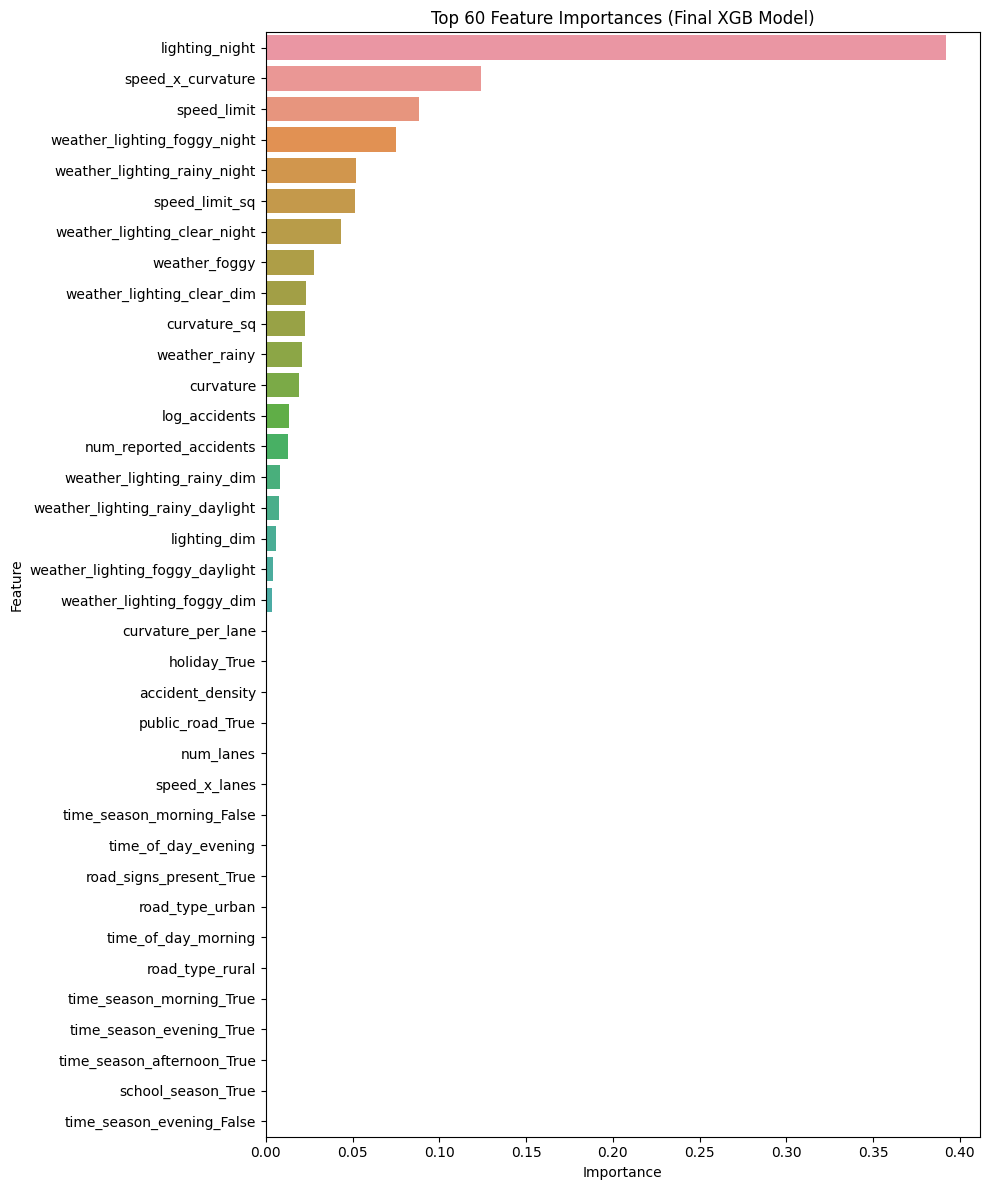


Generating Feature Importance Plot (LGBM)...


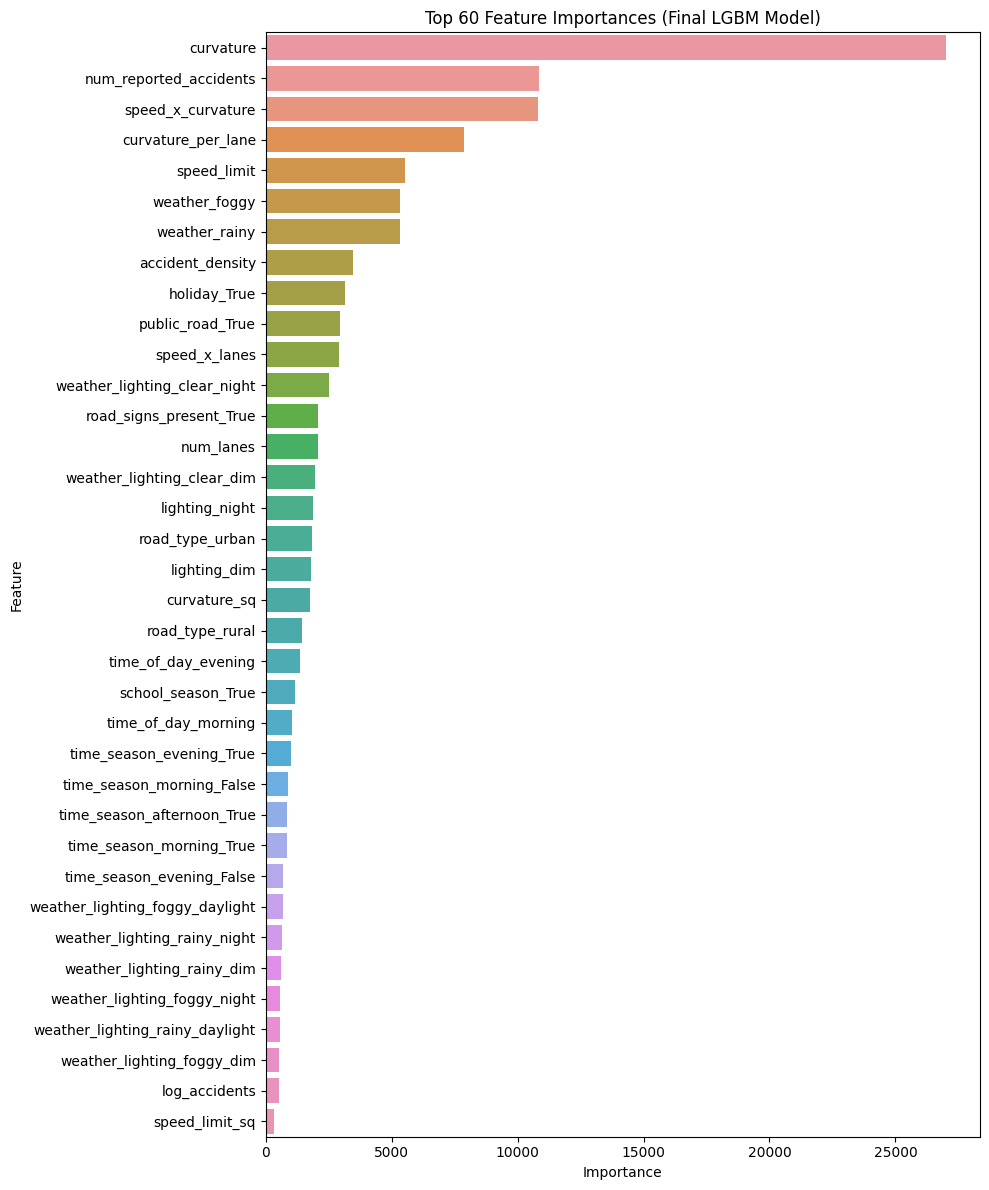

In [16]:
# %% [code]
# --- Feature Importance (from final XGB model) ---
if hasattr(final_model_xgb, 'feature_importances_'):
    print("\nGenerating Feature Importance Plot (XGB)...")
    importances = final_model_xgb.feature_importances_

    feature_importance_df = pd.DataFrame({
        'Feature': feature_names, # Use stored feature names
        'Importance': importances
    }).sort_values('Importance', ascending=False)

    plt.figure(figsize=(10, max(12, len(feature_names) // 4))) # Adjust height based on num features
    sns.barplot(
        data=feature_importance_df.head(60), # Plot top 60 or adjust as needed
        x='Importance',
        y='Feature'
    )
    plt.title('Top 60 Feature Importances (Final XGB Model)')
    plt.tight_layout()
    plt.show()
else:
    print("\nFinal XGB model does not have feature_importances_.")

# Optional: LGBM Importance
if hasattr(final_model_lgbm, 'feature_importances_'):
    print("\nGenerating Feature Importance Plot (LGBM)...")
    importances_lgbm = final_model_lgbm.feature_importances_

    feature_importance_df_lgbm = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances_lgbm
    }).sort_values('Importance', ascending=False)

    plt.figure(figsize=(10, max(12, len(feature_names) // 4)))
    sns.barplot(
        data=feature_importance_df_lgbm.head(60),
        x='Importance',
        y='Feature'
    )
    plt.title('Top 60 Feature Importances (Final LGBM Model)')
    plt.tight_layout()
    plt.show()
else:
    print("\nFinal LGBM model does not have feature_importances_.")